# BBC GoodFood Soup Analysis
- Most popular ingredients
- Number of vegan friendly/beginner friendly/healthy soups
- Date & year published: trends in soup tastes

## Import packages

In [2]:
import requests 
import pandas as pd
from bs4 import BeautifulSoup
from re import search
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
#import spacy


## Web scraping
Scraping BBC GoodFood website for the search "Soup Recipes" with the filter "soup" to *soup.csv* file

In [54]:
base_url = "https://www.bbcgoodfood.com/search?q=Soup+recipe+ideas&tab=recipe&mealType=soup"
start_page = 1  
end_page = 11

In [65]:
# creating (testing stage) function for getting more details on recipe
test_url = "https://www.bbcgoodfood.com/recipes/mushroom-soup"

authors = []
prep_times = []
cook_times = []
difficulties = []
servings = []
dates_published = []
ingredients_strs = []

response = requests.get(test_url)
soup = BeautifulSoup(response.content, "html.parser")

#author
author_link = soup.find('a', class_='link link--styled') 
author_n = author_link.text

#prep details
prep_details = soup.find_all("div", class_='recipe-cook-and-prep-details__item')
prep_details_list = []
for d in prep_details:
    prep_details_list.append(d)
i = 0
for i in range(4):
    if i == 0:
        serving = prep_details[i].find("strong").text.strip()
    elif i == 1:
        difficulty = prep_details[i].find("strong").text.strip()
    elif i == 2:
        prep_time = prep_details[i].find("time").text.strip()
    elif i == 3:
        if len(prep_details_list) > 3:
            cook_time = prep_details[i].find("time").text.strip()if prep_details[i].find("time") else "NA"
        else:
            cook_time = "NA"
    i = i+1

#ingredients list
ingredients_str = ""
ingredients_raw = soup.find_all("li", {'class':['ingredients-list__item list-item list-item--separator-top', "ingredients-list__item list-item"]})
for i in ingredients_raw:
    ingredient = i.get_text()
    if len(ingredients_str) == 0:
        ingredients_str = ingredients_str + ingredient
    elif len(ingredients_str) > 0:
        ingredients_str = ingredients_str + ", " + ingredient
    print(ingredients_str)

# date published
date_published = soup.find("p", class_= "post__publication-link hidden-print").text.strip() if soup.find("p", class_="post__publication-link hidden-print") else "NA"

# append to lists
authors.append(author_n)
servings.append(serving)
prep_times.append(prep_time)
cook_times.append(cook_time)
ingredients_strs.append(ingredients_str)
dates_published.append(date_published)

print(authors)
print(servings)
print(prep_times)
print(cook_times)
print(ingredients_strs)
print(dates_published)


90g butter
90g butter, 2 medium onions roughly chopped
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed 
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well)
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well), 2 tbsp plain flour
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well), 2 tbsp plain flour, 1l hot chicken stock
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well), 2 tbsp plain flour, 1l hot chicken stock, 1 bay leaf
90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well), 2 tbsp plain flour, 1l hot chicken stock, 1 bay leaf, 

In [77]:
# create funciton to extract extra details
def indiv_scrape(recipe_url):
    response = requests.get(recipe_url)    
    soup = BeautifulSoup(response.content, "html.parser")

    # extract extra info
    #author
    author_link = soup.find('a', class_='link link--styled') 
    author_n = author_link.text

    #prep details
    prep_details = soup.find_all("div", class_='recipe-cook-and-prep-details__item')
    prep_details_list = []
    for d in prep_details:
        prep_details_list.append(d)
    i = 0
    for i in range(4):
        if i == 0:
            serving = prep_details[i].find("strong").text.strip()
        elif i == 1:
            difficulty = prep_details[i].find("strong").text.strip()
        elif i == 2:
            if len(prep_details_list) > 2:
                prep_time = prep_details[i].find("time").text.strip()if prep_details[i].find("time") else "NA"
            else:
                prep_time = "NA"
        elif i == 3:
            if len(prep_details_list) > 3:
                cook_time = prep_details[i].find("time").text.strip()if prep_details[i].find("time") else "NA"
            else:
                cook_time = "NA"
        i = i+1
        
    #ingredients list
    ingredients_str = ""
    ingredients_raw = soup.find_all("li", {'class':['ingredients-list__item list-item list-item--separator-top', "ingredients-list__item list-item"]})
    for i in ingredients_raw:
        ingredient = i.get_text()
        if len(ingredients_str) == 0:
            ingredients_str = ingredients_str + ingredient
        elif len(ingredients_str) > 0:
            ingredients_str = ingredients_str + ", " + ingredient

    # date published
    date_published = soup.find("p", class_= "post__publication-link hidden-print").text.strip() if soup.find("p", class_="post__publication-link hidden-print") else "NA"

    
    # append to list
    more_details = [author_n, serving, difficulty, prep_time, cook_time, ingredients_str, date_published]
    
    return more_details

this function allows us to isolate each page and extract more details about the recipe in the more_details list. this consists of the following items and their corresponding indices:
- [0] = author name
- [1] = serving size
- [2] = difficulty (easy, intermediate, hard)
- [3] = preparaiton time
- [4] = cooking time
- [5] = a list containing ingredients in the recipe
- [6] = date published

In [78]:
# make lists for storing data 
titles = []
summaries = []
ratings = []
rating_qtys = []
urls = []
authors = []
prep_times = []
cook_times = []
difficulties = []
servings = []
dates_published = []
ingredients_strs = []

# sart scraping
for page in range(start_page, end_page + 1):
    print(f"Scraping page {page}...")
    url = f"{base_url}&page={page}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch page {page}, status code: {response.status_code}")
        continue
    
    soup = BeautifulSoup(response.content, "html.parser")
    
    recipes = soup.find_all("div", class_="search-result--list")  
    
    for recipe in recipes:
        title = recipe.find("h2", class_="heading-4").text.strip()        
        rating = recipe.find("span", class_="sr-only").text.strip()
        rating_qty = recipe.find("span", class_="rating__count-text").text.strip()
        url = recipe.find("a", class_="d-block")["href"]
        #on to the details
        details = indiv_scrape(url)
        author = details[0]
        serving = details[1]
        difficulty = details[2]
        prep_time = details[3]
        cook_time = details[4]
        ingredients_str = details[5]
        date_published = details[6]

        # append to lists
        titles.append(title)
        ratings.append(rating)
        rating_qtys.append(rating_qty)
        urls.append(url)
        authors.append(author)
        servings.append(serving)
        difficulties.append(difficulty)
        prep_times.append(prep_time)
        cook_times.append(cook_time)
        ingredients_strs.append(ingredients_str)
        dates_published.append(date_published)


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...


In [79]:
print(len(titles))
print(len(ratings))
print(len(rating_qtys))
print(len(urls))
print(len(dates_published))

323
323
323
323
323


In [81]:
print(ingredients_strs)

['900ml chicken or vegetable stock (or Miso soup mix), 1 boneless, skinless chicken breast (about 175g), 1 tsp chopped  fresh ginger, 1 garlic clove finely chopped, 50g rice or wheat noodles, 2 tbsp  sweetcorn canned or frozen, 2-3 mushrooms thinly sliced, 2 spring onions shredded, 2 tsp  soy sauce plus extra for serving, mint or basil leaves and a little shredded chilli (optional), to serve', '90g butter, 2 medium onions roughly chopped, 1 garlic clove crushed , 500g mushrooms finely chopped (chestnut or button mushrooms work well), 2 tbsp plain flour, 1l hot chicken stock, 1 bay leaf, 4 tbsp single cream, small handful flat-leaf parsley roughly chopped, to serve (optional)', '1-1.25kg/2lb 4oz-2lb 12oz ripe  tomatoes, 1 medium onion, 1 small carrot, 1 celery stick, 2 tbsp olive oil, 2 squirts of tomato purée (about 2 tsp), a good pinch of sugar, 2 bay leaves, 1.2 litres/2 pints hot vegetable stock (made with boiling water and 4 rounded tsp bouillon powder or 2 stock cubes)', '2 litres

In [82]:
# create df for data
data = {
    "title": titles,
    "rating": ratings,
    "no_of_ratings": rating_qtys,
    "url": urls,
    "author": authors,
    "servings": servings,
    "difficulty": difficulties,
    "prep_time": prep_times,
    "cook_time": cook_times,
    "ingredients": ingredients_strs,
    "date": dates_published
}
souprecipe = pd.DataFrame(data)
souprecipe.to_csv("soup_reps.csv", index=False)

# Cleaning soup_reps.csv

In [83]:
soups = pd.read_csv('soup_reps.csv')
soups.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,ingredients,date
0,Chicken noodle soup,A star rating of 4.8 out of 5.,847 ratings,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,Serves 2,Easy,10 mins,30 mins,900ml chicken or vegetable stock (or Miso soup...,"Recipe from Good Food magazine, February 2006"
1,Mushroom soup,A star rating of 4.8 out of 5.,377 ratings,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,Serves 4,Easy,10 mins,25 mins,"90g butter, 2 medium onions roughly chopped, 1...",NaN
2,Tomato soup,A star rating of 4.6 out of 5.,465 ratings,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,serves 4 for lunch or 6 as a starter,Easy,1 hr and 45 mins,NaN,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me...","Recipe from Good Food magazine, September 2002"
3,Lentil soup,A star rating of 4.6 out of 5.,152 ratings,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,Serves 4,Easy,10 mins,1 hr,"2 litres vegetable or ham stock, 150g red lent...",NaN
4,Cauliflower soup,A star rating of 4.3 out of 5.,136 ratings,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,Serves 4-6,Easy,15 mins,25 mins,"1 large cauliflower (1.5kg), cut into florets ...",NaN


## Clean ingredients column

In [14]:
# clean ingredients columns

# test ingredient list function
#test_ins =soups.iloc[0]['ingredients'].split(' ')
#print(test_ins)
#test_clean = []

#filters
#filter_list =['tsp', 'tbsp', 'serve']
#stops = stopwords.words('english')
#filters = stops + filter_list

#print(filters)
#for n in ins:
#    n = re.sub(r'[^\w\s]', '', n)
#    if re.search(r"([0-9]+[a-zA-Z]?)", n):
#        continue
#    elif n not in filters:
#        test_clean.append(n)

#print(test_clean)

In [15]:
#filters
#filter_list =['tsp', 'tbsp', 'serve', 'pinch']
#stops = stopwords.words('english')
#filters = stops + filter_list
#print(filters)

In [16]:
#def get_ingredients(col):
#    col_split = col.split(' ')
#    ins_clean = ""
#    for n in col_split:
#        n = re.sub(r'[^\w\s]', '', n)
#        if re.search(r"([0-9]+[a-zA-Z]?)", n):
#            continue
#        elif n not in filters:
#            ins_clean += str(n)
#            ins_clean += ", "
#    return ins_clean
#
#soups["ingredients_clean"] = soups["ingredients"].apply(get_ingredients)

In [85]:
soups.head(10)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,ingredients,date
0,Chicken noodle soup,4.8,847 ratings,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,Serves 2,Easy,10 mins,30 mins,900ml chicken or vegetable stock (or Miso soup...,"Recipe from Good Food magazine, February 2006"
1,Mushroom soup,4.8,377 ratings,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,Serves 4,Easy,10 mins,25 mins,"90g butter, 2 medium onions roughly chopped, 1...",NaN
2,Tomato soup,4.6,465 ratings,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,serves 4 for lunch or 6 as a starter,Easy,1 hr and 45 mins,NaN,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me...","Recipe from Good Food magazine, September 2002"
3,Lentil soup,4.6,152 ratings,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,Serves 4,Easy,10 mins,1 hr,"2 litres vegetable or ham stock, 150g red lent...",NaN
4,Cauliflower soup,4.3,136 ratings,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,Serves 4-6,Easy,15 mins,25 mins,"1 large cauliflower (1.5kg), cut into florets ...",NaN
5,Versatile veg soup,4.8,144 ratings,https://www.bbcgoodfood.com/recipes/versatile-...,Good Food team,Serves 2,Easy,10 mins,15 mins,"200g chopped vegetables such as onions, celer...","Recipe from Good Food magazine, November 2008"
6,Butternut squash soup,4.8,753 ratings,https://www.bbcgoodfood.com/recipes/butternut-...,Good Food team,Serves 4,Easy,15 mins,50 mins,"1 butternut squash about 1kg, peeled and desee...","Recipe from Good Food magazine, October 2009"
7,Spiced lentil & butternut squash soup,4.8,238 ratings,https://www.bbcgoodfood.com/recipes/spiced-len...,Esther Clark,Serves 4-6,Easy,10 mins,40 mins,"2 tbsp olive oil, 2 onions finely chopped, 2 g...","Recipe from Good Food magazine, September 2019"
8,Carrot & coriander soup,4.7,734 ratings,https://www.bbcgoodfood.com/recipes/carrot-cor...,Good Food team,Serves 4,Easy,15 mins,25 mins,"1 tbsp vegetable oil, 1 onion chopped, 1 tsp g...","Recipe from Good Food magazine, August 2008"
9,Broccoli & stilton soup,4.9,532 ratings,https://www.bbcgoodfood.com/recipes/broccoli-s...,Caroline Hire – Food writer,Serves 4,Easy,10 mins,35 mins,"2 tbsp rapeseed oil, 1 onion finely chopped, 1...",NaN


## Clean rating column
convert to int

In [84]:
# Clean rating column

soups["rating"] = soups["rating"].str.extract(pat = "A star rating of ([0-9]\.[0-9]) out of 5.")
soups["rating"] = soups["rating"].apply(pd.to_numeric, errors='coerce')
soups.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,ingredients,date
0,Chicken noodle soup,4.8,847 ratings,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,Serves 2,Easy,10 mins,30 mins,900ml chicken or vegetable stock (or Miso soup...,"Recipe from Good Food magazine, February 2006"
1,Mushroom soup,4.8,377 ratings,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,Serves 4,Easy,10 mins,25 mins,"90g butter, 2 medium onions roughly chopped, 1...",NaN
2,Tomato soup,4.6,465 ratings,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,serves 4 for lunch or 6 as a starter,Easy,1 hr and 45 mins,NaN,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me...","Recipe from Good Food magazine, September 2002"
3,Lentil soup,4.6,152 ratings,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,Serves 4,Easy,10 mins,1 hr,"2 litres vegetable or ham stock, 150g red lent...",NaN
4,Cauliflower soup,4.3,136 ratings,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,Serves 4-6,Easy,15 mins,25 mins,"1 large cauliflower (1.5kg), cut into florets ...",NaN


## Clean no_of_ratings column
convert to int

In [86]:
soups["no_of_ratings"] = soups["no_of_ratings"].str.extract(pat = "([0-9]+) ratings")
soups["no_of_ratings"] = soups["no_of_ratings"].apply(pd.to_numeric)

## Clean difficulty column
difficulty_clean = difficulty on a scale of 1(easy) to 3 (difficult)

In [87]:
# Clean difficulty column

def clean_diff(row):
    if row == "Easy":
        return 1
    elif row == "More effort":
        return 2
    elif row == "A challenge":
        return 3
    else:
        return print(row)

soups["difficulty_clean"] = soups["difficulty"].apply(clean_diff)
print(soups.loc[(soups["difficulty"].isin(["10 mins", "50 mins - 1 hr"]))])
# found 2 rows with wrong layout: row 242 & row 319

# correct row values
#print(soups.iloc[242])
#print(soups.iloc[319])

# Correcting row 242: Creamy fish & mussel soup
soupdex1 = soups.loc[soups['title'] == 'Creamy fish & mussel soup'].index[0]
soups.loc[soupdex1, 'cook_time'] = "15 mins"
soups.loc[soupdex1, 'prep_time'] = "10 mins"
soups.loc[soupdex1, 'difficulty'] = "Easy"
# on checking the comments on the Creamy fish & mussel soup recipe, it was determined that it serves 3
soups.loc[soupdex1, 'servings'] = "Serves 3"
soups.loc[soupdex1, 'difficulty_clean'] = 1

# Correcting row 319: Pea & savory soup
soupdex2 = soups.loc[soups['title'] == 'Pea & savory soup'].index[0]
#print(soups.loc[soupdex2])
# No info on servings, cook and prep time -> I'm gonna delete it
soups.drop(index=soupdex2, inplace=True)

10 mins
50 mins - 1 hr
                         title  rating  no_of_ratings  \
237  Creamy fish & mussel soup     NaN            3.0   
317          Pea & savory soup     NaN            0.0   

                                                   url          author  \
237  https://www.bbcgoodfood.com/recipes/creamy-fis...  Good Food team   
317  https://www.bbcgoodfood.com/recipes/pea-savory...  Good Food team   

    servings      difficulty prep_time cook_time  \
237     Easy         10 mins   15 mins       NaN   
317     Easy  50 mins - 1 hr       NaN       NaN   

                                           ingredients  \
237  500g pack mussel in creamy sauce  (find these ...   
317  1 ¼kg peas in their pods, 50g butter, 1 large ...   

                                           date  difficulty_clean  
237  Recipe from Good Food magazine, April 2006               NaN  
317   Recipe from Good Food magazine, June 2002               NaN  


## Clean prep_time column
total_prep_time = number of minutes for prep(int)

In [88]:
#clean prep_time column
pd.unique(soups["prep_time"])
soups["prep_time_num"] = soups["prep_time"].str.extract(r"([0-9]+) mins")
soups["prep_time_num"] = soups["prep_time_num"].apply(pd.to_numeric)

#convert hours to mins
def hour_maker(row1, row2):
    if re.search(r"(1 hr.*)", row1):
        return row2 + 60
    elif re.search(r"(2 hrs.*)", row1):
        return row2 + 120
    else: return row2

soups["total_prep_time"] = soups.apply(lambda x: hour_maker(x["prep_time"], x["prep_time_num"]), axis=1)

## Clean cook_time column
total_cook_time = number of minutes for cooking(int)

In [89]:
#clean cook_time column
print(pd.unique(soups["cook_time"]))
soups["cook_time_num"] = soups["cook_time"].str.extract(r"([0-9]+) mins")
soups["cook_time_num"] = soups["cook_time_num"].apply(pd.to_numeric)
soups["cook_time_num"] = soups["cook_time_num"].replace(np.nan, 0)
soups["cook_time"] = soups["cook_time"].replace(np.nan, "0")

#convert hours to mins
def hour_maker2(col1, col2):
    if re.search(r"([0-9]+ hr.*)", col1):
        n = re.search(r"([0-9]+) hrs?", col1).group(1)
        n = int(n)
        hours = n * 60
        return col2 + hours
    else:
        return col2

soups["total_cook_time"] = soups.apply(lambda x: hour_maker2(x["cook_time"], x["cook_time_num"]), axis=1)

['30 mins' '25 mins' nan '1 hr' '15 mins' '50 mins' '40 mins' '35 mins'
 '22 mins' '55 mins' '20 mins' '45 mins' '10 mins' '1 hr and 10 mins'
 '1 hr and 30 mins' '2 hrs and 15 mins' '1 hr and 20 mins' '5 mins'
 '4 hrs' '6 hrs' '3 hrs' '1 hr and 15 mins' '1 hr and 5 mins' '2 hrs'
 '8 mins' '12 mins' '7 hrs' '36 hrs' '2 hrs and 25 mins']


## Create total_time column
total_time = number of minutes for prep and cook(int)

In [90]:
# make total time column
soups["total_time"] = soups["total_prep_time"] + soups["total_cook_time"]

## Clean date column
- year = year published (int)
- month = month published (str)
- month_num = month_published (int)

In [91]:
# clean date column
soups["year"] = soups["date"].str.extract(r"([0-9][0-9][0-9][0-9])")
soups["year"] = soups["year"].apply(pd.to_numeric)
soups["month"] = soups["date"].str.extract(r"\s([a-zA-z]+)\s[0-9]+")
soups["month"] = soups["month"].replace(np.nan, "NA")

def monther(col):
    if col == "NA":
        return 0
    else:
        return int(datetime.datetime.strptime(col, '%B').month)

#print(pd.unique(soups['month']))
soups["month_num"] = soups["month"].apply(monther)

## Clean servings column
servings_clean = number of servings (int)

In [92]:
soups["servings_num"] = soups["servings"].str.extract(r"[sS]erves ([0-9])")
soups["servings_num"] = soups["servings_num"].apply(pd.to_numeric)

In [93]:
soups.dtypes

title                object
rating              float64
no_of_ratings       float64
url                  object
author               object
servings             object
difficulty           object
prep_time            object
cook_time            object
ingredients          object
date                 object
difficulty_clean    float64
prep_time_num       float64
total_prep_time     float64
cook_time_num       float64
total_cook_time     float64
total_time          float64
year                float64
month                object
month_num             int64
servings_num        float64
dtype: object

In [94]:
soups.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,ingredients,...,difficulty_clean,prep_time_num,total_prep_time,cook_time_num,total_cook_time,total_time,year,month,month_num,servings_num
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,Serves 2,Easy,10 mins,30 mins,900ml chicken or vegetable stock (or Miso soup...,...,1.0,10.0,10.0,30.0,30.0,40.0,2006.0,February,2,2.0
1,Mushroom soup,4.8,377.0,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,Serves 4,Easy,10 mins,25 mins,"90g butter, 2 medium onions roughly chopped, 1...",...,1.0,10.0,10.0,25.0,25.0,35.0,NaN,NA,0,4.0
2,Tomato soup,4.6,465.0,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,serves 4 for lunch or 6 as a starter,Easy,1 hr and 45 mins,0,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me...",...,1.0,45.0,105.0,0.0,0.0,105.0,2002.0,September,9,4.0
3,Lentil soup,4.6,152.0,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,Serves 4,Easy,10 mins,1 hr,"2 litres vegetable or ham stock, 150g red lent...",...,1.0,10.0,10.0,0.0,60.0,70.0,NaN,NA,0,4.0
4,Cauliflower soup,4.3,136.0,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,Serves 4-6,Easy,15 mins,25 mins,"1 large cauliflower (1.5kg), cut into florets ...",...,1.0,15.0,15.0,25.0,25.0,40.0,NaN,NA,0,4.0


## Get cleaned soup CSV

In [95]:
soups.columns

Index(['title', 'rating', 'no_of_ratings', 'url', 'author', 'servings',
       'difficulty', 'prep_time', 'cook_time', 'ingredients', 'date',
       'difficulty_clean', 'prep_time_num', 'total_prep_time', 'cook_time_num',
       'total_cook_time', 'total_time', 'year', 'month', 'month_num',
       'servings_num'],
      dtype='object')

In [96]:
soup_t = soups[['title','rating','no_of_ratings','url','author', 'servings_num', 'difficulty_clean','total_prep_time','total_cook_time','total_time','year','month_num','ingredients']].copy()

## Clean soup_t

In [97]:
soup_t = soup_t.rename(columns={
    'servings_num': 'servings', 
    'difficulty_clean': 'difficulty', 
    'total_prep_time': 'prep_time',
    'total_cook_time': 'cook_time',
    'month_num': 'month',
    'ingredients': 'ingredients'
})


In [98]:
soup_t['year'] = soup_t['year'].fillna("0").astype(int)

In [99]:
soup_t.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,900ml chicken or vegetable stock (or Miso soup...
1,Mushroom soup,4.8,377.0,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,4.0,1.0,10.0,25.0,35.0,0,0,"90g butter, 2 medium onions roughly chopped, 1..."
2,Tomato soup,4.6,465.0,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,4.0,1.0,105.0,0.0,105.0,2002,9,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me..."
3,Lentil soup,4.6,152.0,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,4.0,1.0,10.0,60.0,70.0,0,0,"2 litres vegetable or ham stock, 150g red lent..."
4,Cauliflower soup,4.3,136.0,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,4.0,1.0,15.0,25.0,40.0,0,0,"1 large cauliflower (1.5kg), cut into florets ..."


In [100]:
def datemaker(year, month):
    if year == 0:
        date = 0
    else:
        date = datetime.datetime(year, month, 1)
    return date

In [101]:
soup_t["date"] = soup_t.apply(lambda x: datemaker(x["year"], x["month"]), axis=1)

In [102]:
soup_t.columns

Index(['title', 'rating', 'no_of_ratings', 'url', 'author', 'servings',
       'difficulty', 'prep_time', 'cook_time', 'total_time', 'year', 'month',
       'ingredients', 'date'],
      dtype='object')

In [104]:
# save soup_t to soup_clean
soup_t.to_csv("soup_clean.csv", index=False)

## The soup_clean.csv
Dataset derived from web scraping BBC Good Food Soup recipes
- title: name of soup
- rating: rating of recipe on the BBC Good Food website
- no_of_ratings: number of ratings
- url: URL of recipe
- author: author of recipe
- servings: number of people soup serves
- difficulty: difficulty of recipe rated on a scale of 1-3, where 1 = Easy and 3 = difficult]
- prep_time: time needed to prepare recipe. Some recipes do not separate prep time and cook time, and these timings are categorised under prep_time
- cook_time: time needed to cook recipe
- total_time: total prep and cook time
- year: year recipe was published
- month: month recipe was published
- ingredients: list (str) of ingredients in recipe
- date: datetime object of month & year recipe was published

# Exploring soup dataset
I want to analyse a few things from this web scraping
- Which authors have the highest rating? -> who is the best BBC GoodFood Souper?

Trends in soups throughout the years: 
- does prep/cook/total time change throughout the years?
- popular ingredients throughout time
- difficulty throughout the years?

Trends in soups throughout each year: 
- prep/cook/total time throughout the seasons
- popular ingredients throughout the seasons
- difficulty

other related datasets:
- https://www.gov.uk/government/statistical-data-sets/family-food-datasets
- https://docs.google.com/spreadsheets/d/1nxMr_yHq-lbPQoSbKbjQbrvqhQy5c4VtqCTdDoShZjY/edit?gid=957640065#gid=957640065


In [5]:
# Load up the big boy
soupy = pd.read_csv('soup_clean.csv')
soupy.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,900ml chicken or vegetable stock (or Miso soup...,2006-02-01 00:00:00
1,Mushroom soup,4.8,377.0,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,4.0,1.0,10.0,25.0,35.0,0,0,"90g butter, 2 medium onions roughly chopped, 1...",0
2,Tomato soup,4.6,465.0,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,4.0,1.0,105.0,0.0,105.0,2002,9,"1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 me...",2002-09-01 00:00:00
3,Lentil soup,4.6,152.0,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,4.0,1.0,10.0,60.0,70.0,0,0,"2 litres vegetable or ham stock, 150g red lent...",0
4,Cauliflower soup,4.3,136.0,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,4.0,1.0,15.0,25.0,40.0,0,0,"1 large cauliflower (1.5kg), cut into florets ...",0


In [82]:
soupy['rating'] = soupy['rating'].replace(np.nan, 0)
soupy['no_of_ratings'] = soupy['no_of_ratings'].replace(np.nan, 0)

## Most popular/least popular soups

In [83]:
# Most popular soups by rating
soupy.sort_values(by='rating', ascending = False)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
12,Soup maker broccoli and stilton soup,4.9,83.0,https://www.bbcgoodfood.com/recipes/soup-maker...,Good Food team,4.0,1.0,5.0,30.0,35.0,0,0,"onion, finely, chopped, , celery, stick, slice...",0
10,Broccoli & stilton soup,4.9,527.0,https://www.bbcgoodfood.com/recipes/broccoli-s...,Caroline Hire – Food writer,4.0,1.0,10.0,35.0,45.0,0,0,"rapeseed, oil, onion, finely, chopped, stick, ...",0
49,Pumpkin & bacon soup,4.9,41.0,https://www.bbcgoodfood.com/recipes/pumpkin-ba...,Tom Kerridge,4.0,1.0,10.0,70.0,80.0,2016,10,"vegetable, oil, butter, onion, finely, chopped...",2016-10-01 00:00:00
43,Thai chicken and sweet potato soup,4.9,149.0,https://www.bbcgoodfood.com/recipes/thai-chick...,Caroline Hire – Food writer,2.0,1.0,5.0,30.0,35.0,0,0,"olive, rapeseed, oil, garlic, cloves, chopped,...",0
117,Truffled Jerusalem artichoke soup,4.9,9.0,https://www.bbcgoodfood.com/recipes/truffled-j...,Tom Kerridge,4.0,1.0,25.0,35.0,60.0,2016,12,"butter, onions, sliced, Jerusalem, artichoke, ...",2016-12-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,Creamy spring soup with goat's cheese & prosci...,0.0,2.0,https://www.bbcgoodfood.com/recipes/creamy-spr...,Cassie Best,8.0,1.0,25.0,30.0,55.0,2015,4,"olive, rapeseed, oil, onion, chopped, fennel, ...",2015-04-01 00:00:00
219,Watercress soup with bacon dumplings,0.0,0.0,https://www.bbcgoodfood.com/recipes/watercress...,Richard Corrigan,6.0,1.0,30.0,30.0,60.0,2015,5,"butter, garlic, cloves, crushed, onions, finel...",2015-05-01 00:00:00
217,Chickpea soup with coriander & lime,0.0,7.0,https://www.bbcgoodfood.com/recipes/chickpea-s...,Good Food team,4.0,1.0,10.0,20.0,30.0,2006,12,"butter, softened, chopped, fresh, , coriander,...",2006-12-01 00:00:00
210,Haddock & sweetcorn soup,0.0,5.0,https://www.bbcgoodfood.com/recipes/haddock-sw...,Good Food team,4.0,1.0,10.0,20.0,30.0,2009,3,"medium, potatoes, chopped, fullfat, milk, hot,...",2009-03-01 00:00:00


In [84]:
# too many soups with a 4.9 rating. Let's also rank them by number of ratings
soupy.sort_values(by=['rating', 'no_of_ratings'], ascending = False)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
10,Broccoli & stilton soup,4.9,527.0,https://www.bbcgoodfood.com/recipes/broccoli-s...,Caroline Hire – Food writer,4.0,1.0,10.0,35.0,45.0,0,0,"rapeseed, oil, onion, finely, chopped, stick, ...",0
8,Spiced lentil & butternut squash soup,4.9,236.0,https://www.bbcgoodfood.com/recipes/spiced-len...,Esther Clark,4.0,1.0,10.0,40.0,50.0,2019,9,"olive, oil, onions, finely, chopped, garlic, c...",2019-09-01 00:00:00
43,Thai chicken and sweet potato soup,4.9,149.0,https://www.bbcgoodfood.com/recipes/thai-chick...,Caroline Hire – Food writer,2.0,1.0,5.0,30.0,35.0,0,0,"olive, rapeseed, oil, garlic, cloves, chopped,...",0
12,Soup maker broccoli and stilton soup,4.9,83.0,https://www.bbcgoodfood.com/recipes/soup-maker...,Good Food team,4.0,1.0,5.0,30.0,35.0,0,0,"onion, finely, chopped, , celery, stick, slice...",0
112,"Creamy smoked salmon, leek & potato soup",4.9,48.0,https://www.bbcgoodfood.com/recipes/creamy-smo...,Good Food team,8.0,1.0,15.0,25.0,40.0,2010,12,"large, knob, butter, large, , leeks, halved, f...",2010-12-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Gazpacho with runner bean tempura & pickled co...,0.0,0.0,https://www.bbcgoodfood.com/recipes/gazpacho-r...,Rosie Birkett,4.0,2.0,30.0,10.0,40.0,2017,8,"white, wine, vinegar, sherry, vinegar, caster,...",2017-08-01 00:00:00
308,Watercress & artichoke soup,0.0,0.0,https://www.bbcgoodfood.com/recipes/watercress...,Sara Buenfeld,2.0,1.0,5.0,8.0,13.0,2014,8,"potato, grated, skin, spring, onions, chopped,...",2014-08-01 00:00:00
311,Courgette soup with parmesan and burnt chilli ...,0.0,0.0,https://www.bbcgoodfood.com/recipes/courgette-...,Good Food team,4.0,2.0,65.0,60.0,125.0,0,0,"corn, flour, sieved, vegetable, oil, sheets, g...",0
322,"Creamy chilled basil, pea & lettuce soup",0.0,0.0,https://www.bbcgoodfood.com/recipes/creamy-chi...,Good Food team,4.0,1.0,15.0,0.0,15.0,2005,6,"fresh, frozen, peas, large, bunch, basil, leav...",2005-06-01 00:00:00


**The top five soups are:**
*do more research on these*
1. Broccoli & stilton soup	
   
2. Spiced lentil & butternut squash soup

3. Thai chicken and sweet potato soup

4. Soup maker broccoli and stilton soup

5. Creamy smoked salmon, leek & potato soup	

In [85]:
soupy.sort_values(by='rating', ascending = True)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
323,Tomato consommé with Lancashire cheese on toast,0.0,0.0,https://www.bbcgoodfood.com/recipes/tomato-con...,Good Food team,6.0,2.0,40.0,145.0,185.0,2010,7,"ripe, plum, tomato, quartered, white, wine, to...",2010-07-01 00:00:00
220,Creamy spring soup with goat's cheese & prosci...,0.0,2.0,https://www.bbcgoodfood.com/recipes/creamy-spr...,Cassie Best,8.0,1.0,25.0,30.0,55.0,2015,4,"olive, rapeseed, oil, onion, chopped, fennel, ...",2015-04-01 00:00:00
219,Watercress soup with bacon dumplings,0.0,0.0,https://www.bbcgoodfood.com/recipes/watercress...,Richard Corrigan,6.0,1.0,30.0,30.0,60.0,2015,5,"butter, garlic, cloves, crushed, onions, finel...",2015-05-01 00:00:00
217,Chickpea soup with coriander & lime,0.0,7.0,https://www.bbcgoodfood.com/recipes/chickpea-s...,Good Food team,4.0,1.0,10.0,20.0,30.0,2006,12,"butter, softened, chopped, fresh, , coriander,...",2006-12-01 00:00:00
215,Smoky tomato soup with preserved lemon & green...,0.0,0.0,https://www.bbcgoodfood.com/recipes/smoky-toma...,Diana Henry,4.0,1.0,25.0,20.0,45.0,2019,4,"soft, butter, olive, oil, large, onion, choppe...",2019-04-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,Smoked haddock & leek chowder,4.9,36.0,https://www.bbcgoodfood.com/recipes/smoked-had...,Jo Pratt,4.0,1.0,40.0,0.0,40.0,2005,2,"natural, undyed, smoked, haddock, milk, olive,...",2005-02-01 00:00:00
12,Soup maker broccoli and stilton soup,4.9,83.0,https://www.bbcgoodfood.com/recipes/soup-maker...,Good Food team,4.0,1.0,5.0,30.0,35.0,0,0,"onion, finely, chopped, , celery, stick, slice...",0
159,Boxing Day soup,4.9,12.0,https://www.bbcgoodfood.com/recipes/boxing-day...,Good Food team,4.0,1.0,45.0,0.0,45.0,2002,1,"sunflower, oil, onion, chopped, celery, sticks...",2002-01-01 00:00:00
8,Spiced lentil & butternut squash soup,4.9,236.0,https://www.bbcgoodfood.com/recipes/spiced-len...,Esther Clark,4.0,1.0,10.0,40.0,50.0,2019,9,"olive, oil, onions, finely, chopped, garlic, c...",2019-09-01 00:00:00


**The least popular five soups are:**
*do more research on these*
1. Easy miso soup
   
2. Spinach & watercress soup	

3. Fragrant cucumber & yogurt soup

4. Japanese tofu noodle bowl

5. Healthy carrot soup

In [86]:
# Most/Least popular soups by number of ratings: proxy for number of people making it
soupy.sort_values(by='no_of_ratings', ascending = False)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
0,Spiced carrot & lentil soup,4.6,1454.0,https://www.bbcgoodfood.com/recipes/spiced-car...,Jane Hornby,4.0,1.0,10.0,15.0,25.0,2005,10,"cumin, seeds, chilli, flakes, olive, oil, carr...",2005-10-01 00:00:00
11,"Red lentil, chickpea & chilli soup",4.8,895.0,https://www.bbcgoodfood.com/recipes/red-lentil...,Good Food team,4.0,1.0,10.0,25.0,35.0,2010,3,"cumin, seeds, large, chilli, flakes, olive, oi...",2010-03-01 00:00:00
1,Chicken noodle soup,4.8,839.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,"chicken, vegetable, stock, Miso, soup, mix, bo...",2006-02-01 00:00:00
7,Butternut squash soup,4.8,750.0,https://www.bbcgoodfood.com/recipes/butternut-...,Good Food team,4.0,1.0,15.0,50.0,65.0,2009,10,"butternut, squash, peeled, deseeded, olive, oi...",2009-10-01 00:00:00
9,Carrot & coriander soup,4.7,727.0,https://www.bbcgoodfood.com/recipes/carrot-cor...,Good Food team,4.0,1.0,15.0,25.0,40.0,2008,8,"vegetable, oil, onion, chopped, ground, corian...",2008-08-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Wonton soup,0.0,0.0,https://www.bbcgoodfood.com/recipes/wonton-soup,Ching-He Huang,4.0,1.0,20.0,10.0,30.0,0,0,"pack, , frozen, wonton, wrappers, defrosted, ,...",0
269,Summery soup with pesto,0.0,0.0,https://www.bbcgoodfood.com/recipes/summery-so...,Good Food team,4.0,1.0,15.0,0.0,15.0,2005,8,"courgette, halved, thinly, sliced, , frozen, p...",2005-08-01 00:00:00
311,Courgette soup with parmesan and burnt chilli ...,0.0,0.0,https://www.bbcgoodfood.com/recipes/courgette-...,Good Food team,4.0,2.0,65.0,60.0,125.0,0,0,"corn, flour, sieved, vegetable, oil, sheets, g...",0
308,Watercress & artichoke soup,0.0,0.0,https://www.bbcgoodfood.com/recipes/watercress...,Sara Buenfeld,2.0,1.0,5.0,8.0,13.0,2014,8,"potato, grated, skin, spring, onions, chopped,...",2014-08-01 00:00:00


**The most popular five soups are:**
*do more research on these*
1. Spiced carrot & lentil soup
   
2. Red lentil, chickpea & chilli soup	

3. Chicken noodle soup

4. Butternut squash soup

5. Carrot & coriander soup

In [87]:
soupy.sort_values(by='no_of_ratings', ascending = True)

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
323,Tomato consommé with Lancashire cheese on toast,0.0,0.0,https://www.bbcgoodfood.com/recipes/tomato-con...,Good Food team,6.0,2.0,40.0,145.0,185.0,2010,7,"ripe, plum, tomato, quartered, white, wine, to...",2010-07-01 00:00:00
215,Smoky tomato soup with preserved lemon & green...,0.0,0.0,https://www.bbcgoodfood.com/recipes/smoky-toma...,Diana Henry,4.0,1.0,25.0,20.0,45.0,2019,4,"soft, butter, olive, oil, large, onion, choppe...",2019-04-01 00:00:00
236,Asparagus soup with tartines,0.0,0.0,https://www.bbcgoodfood.com/recipes/asparagus-...,Sarah Cook,6.0,1.0,5.0,35.0,40.0,2015,5,"onions, sliced, butter, asparagus, snapping, w...",2015-05-01 00:00:00
322,"Creamy chilled basil, pea & lettuce soup",0.0,0.0,https://www.bbcgoodfood.com/recipes/creamy-chi...,Good Food team,4.0,1.0,15.0,0.0,15.0,2005,6,"fresh, frozen, peas, large, bunch, basil, leav...",2005-06-01 00:00:00
305,Gazpacho with runner bean tempura & pickled co...,0.0,0.0,https://www.bbcgoodfood.com/recipes/gazpacho-r...,Rosie Birkett,4.0,2.0,30.0,10.0,40.0,2017,8,"white, wine, vinegar, sherry, vinegar, caster,...",2017-08-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,Carrot & coriander soup,4.7,727.0,https://www.bbcgoodfood.com/recipes/carrot-cor...,Good Food team,4.0,1.0,15.0,25.0,40.0,2008,8,"vegetable, oil, onion, chopped, ground, corian...",2008-08-01 00:00:00
7,Butternut squash soup,4.8,750.0,https://www.bbcgoodfood.com/recipes/butternut-...,Good Food team,4.0,1.0,15.0,50.0,65.0,2009,10,"butternut, squash, peeled, deseeded, olive, oi...",2009-10-01 00:00:00
1,Chicken noodle soup,4.8,839.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,"chicken, vegetable, stock, Miso, soup, mix, bo...",2006-02-01 00:00:00
11,"Red lentil, chickpea & chilli soup",4.8,895.0,https://www.bbcgoodfood.com/recipes/red-lentil...,Good Food team,4.0,1.0,10.0,25.0,35.0,2010,3,"cumin, seeds, large, chilli, flakes, olive, oi...",2010-03-01 00:00:00


**The least popular five soups are:**
*these sound so cursed*
1. Wonton soup
   
2. Watercress & artichoke soup	

3. Courgette soup with parmesan and burnt chilli marshmallow

4. Salsa soup

5. Cappuccino of white beans

WHICH SOUPS DO NOT HAVE ANY RATINGS?

## Best/worst soupers

In [88]:
soupscores = pd.pivot_table(soupy, values=['rating', 'no_of_ratings', 'difficulty', 'total_time', 'year'], index=['author'],
                       aggfunc={'rating': "mean", 'no_of_ratings': "sum", 'difficulty':'mean', 'total_time':'mean'})
soupscores = soupscores.reset_index('author')

In [89]:
rows, columns = soupscores.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 60, Columns: 5


In [90]:
soupscores = soupscores.sort_values(by="rating")
# wow this is really embarrasing 

In [91]:
soupscores

,author,difficulty,no_of_ratings,rating,total_time
3,Bill Granger,1.000000,2.0,0.000000,10.000000
45,Olia Hercules,1.000000,5.0,0.000000,140.000000
48,Richard Corrigan,1.000000,0.0,0.000000,60.000000
49,Rosie Birkett,1.500000,5.0,0.000000,47.000000
52,Sarah Cook,1.000000,96.0,1.566667,43.333333
11,Diana Henry,1.000000,66.0,2.075000,52.500000
18,Gordon Ramsay,1.000000,46.0,2.200000,112.500000
53,Silvana Franco,1.000000,24.0,2.300000,52.500000
10,Ching-He Huang,1.000000,33.0,2.400000,35.000000
25,John Torode,1.000000,82.0,2.766667,115.000000


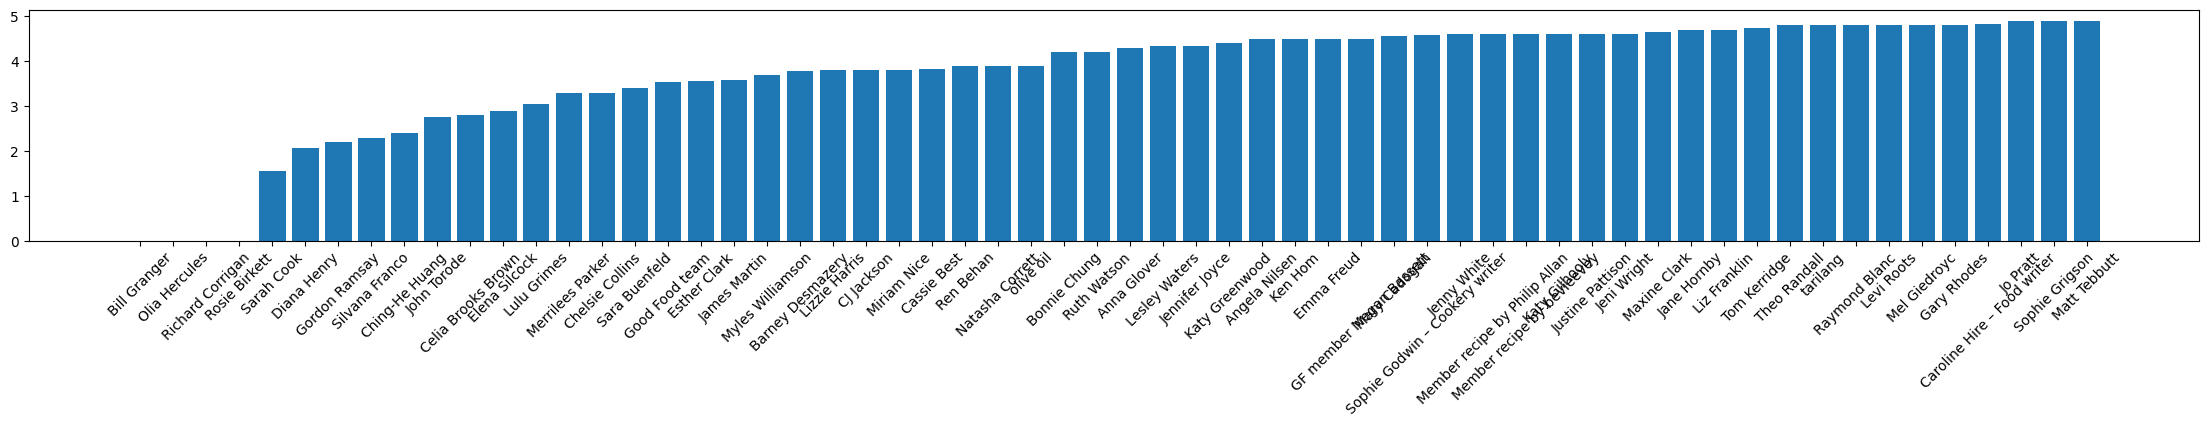

In [92]:
plt.figure(figsize=(28,3))
plt.bar(x=soupscores['author'], height=soupscores['rating'])
plt.xticks(rotation=45)
#ADD TITLE AND STYLE
plt.show()

In [93]:
soupscores = soupscores.sort_values(by="no_of_ratings", ascending=False)
soupscores_filtered = soupscores.iloc[0:10]

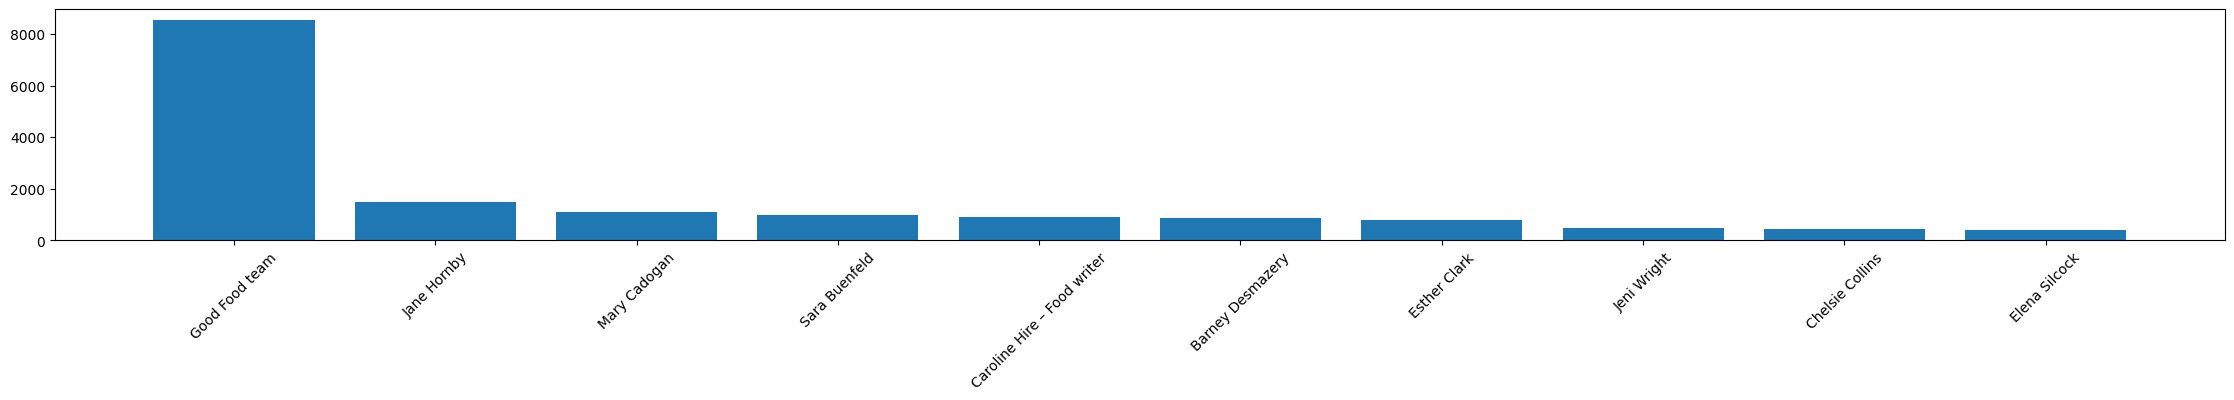

In [94]:
plt.figure(figsize=(28,3))
plt.bar(x=soupscores_filtered['author'], height=soupscores_filtered['no_of_ratings'])
plt.xticks(rotation=45)
#ADD TITLE AND STYLE
plt.show()

# Making the soup by ingredients csv
Credit to https://github.com/shrusti-ghela/cooking-with-NLP/blob/main/allRecipes_text-mining.ipynb. Similar to her work, there are multiple paterns throughout the dataset through which ingredients are described:
- NUMBER INGREDIENT
- NUMBER tbsp/g/lb/oz/tsp/ml/pinch INGREDIENT
- NUMBER INGREDIENT, chopped/diced/sliced
<br>This pattern can be broken down with NLP to isolate the ingredients in the dataset

In [6]:
#convert comma separated values in ingredients to list
soupy['ingredients'] = soupy['ingredients'].str.split(',')
soupy.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,[900ml chicken or vegetable stock (or Miso sou...,2006-02-01 00:00:00
1,Mushroom soup,4.8,377.0,https://www.bbcgoodfood.com/recipes/mushroom-soup,tarilang,4.0,1.0,10.0,25.0,35.0,0,0,"[90g butter, 2 medium onions roughly chopped,...",0
2,Tomato soup,4.6,465.0,https://www.bbcgoodfood.com/recipes/tomato-soup,Jeni Wright,4.0,1.0,105.0,0.0,105.0,2002,9,"[1-1.25kg/2lb 4oz-2lb 12oz ripe tomatoes, 1 ...",2002-09-01 00:00:00
3,Lentil soup,4.6,152.0,https://www.bbcgoodfood.com/recipes/lentil-soup,Member recipe by bevieevey,4.0,1.0,10.0,60.0,70.0,0,0,"[2 litres vegetable or ham stock, 150g red le...",0
4,Cauliflower soup,4.3,136.0,https://www.bbcgoodfood.com/recipes/cauliflowe...,Esther Clark,4.0,1.0,15.0,25.0,40.0,0,0,"[1 large cauliflower (1.5kg), cut into floret...",0


In [14]:
soupy_t = soupy.explode('ingredients') 
soupy_t.dtypes

title             object
rating           float64
no_of_ratings    float64
url               object
author            object
servings         float64
difficulty       float64
prep_time        float64
cook_time        float64
total_time       float64
year               int64
month              int64
ingredients       object
date              object
dtype: object

In [15]:
#add month name column
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
    0: "NA"
}

def monthify(num):
    mnth = month_dict[num]
    return mnth


soupy_t['month_str'] = soupy_t['month'].apply(monthify)

In [17]:
soupy_t.head()

,title,rating,no_of_ratings,url,author,servings,difficulty,prep_time,cook_time,total_time,year,month,ingredients,date,month_str
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,900ml chicken or vegetable stock (or Miso soup...,2006-02-01 00:00:00,February
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,1 boneless,2006-02-01 00:00:00,February
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,skinless chicken breast (about 175g),2006-02-01 00:00:00,February
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,1 tsp chopped fresh ginger,2006-02-01 00:00:00,February
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,Mary Cadogan,2.0,1.0,10.0,30.0,40.0,2006,2,1 garlic clove finely chopped,2006-02-01 00:00:00,February


In [109]:
length = len(soupy_t)
print(length)

3602


In [18]:
#load the existing small model from spacy
nlp = spacy.load('en_core_web_sm')

In [19]:
measurements = re.compile(r'[0-9.]+\s?(l|kg|g|ml|litres|bowl|bulb|can|cube|clove|cup|drop|ounce|oz|lb|pinch|pound|tsp|tbsp)s?')
extracted = []

for ix, row in soupy_t.iterrows():
    print('\r', "Extracting ingredient for row", ix, end='')
    tokens = nlp(row['ingredients'])
    extract = ''
    for token in tokens:
        if (token.dep_ in ['nsubj', 'ROOT']) and (token.pos_ in ['NOUN', 'PROPN']) and (not measurements.match(token.text)):
        #explore children
            for child in token.children:
                if (not measurements.match(child.text)) and (child.dep_ in ['amod', 'compound']):
                    extract += child.text + ' '
            extract += token.text + ' '
    extracted.append(extract)

 Extracting ingredient for row 321

In [20]:
#clean extracted
extrafilter = re.compile(r'[\s]?(¼|½|tbsp|g|tsp|can)\s')
extrafilter_l = ['¼','½', 'tbsp', 'g', 'tsp', 'can','cans','']
extracted_clean = []
for n in extracted:
    n = n.strip()
    if extrafilter.match(n):
        n = re.sub('[\s]?(¼|½|tbsp|g|tsp)\s', '', n)
        extracted_clean.append(n)
    elif n in extrafilter_l:
        n = ''
        extracted_clean.append(n)
    else:
        extracted_clean.append(n)
print(extracted_clean)

['stock', 'boneless', 'skinless chicken breast', '', 'garlic clove', 'rice', '', 'mushrooms', 'spring onions', 'soy sauce', 'leaves', '', 'butter', 'medium onions', 'garlic clove', 'mushrooms', '', 'chicken stock', 'bay leaf', '', 'small handful leaf parsley', '', '', 'medium onion', 'small carrot', 'celery stick', '', 'squirts', 'good pinch', 'bay', 'vegetable stock', 'litres', 'red lentils', 'carrots', 'medium leeks', 'small handful', 'large cauliflower', '', '', '', 'thyme sprigs', 'onion', 'celery stick', '', 'garlic clove', 'veg', 'single cream', '', 'chopped vegetables', 'celery', 'potatoes', '', 'stock', 'crème fraîche', '', '', '', '', 'butter', 'onions', 'garlic clove', 'mild red chillies', 'vegetable stock', '', '', 'onions', 'garlic', '', '', 'butternut', 'red lentils', 'vegetable stock', 'coriander leaves', '', 'dukkah', '', '', 'onion', '', 'potato', 'carrots', 'vegetable', 'handful coriander', '', 'onion', 'stick celery', 'leek', 'medium potato', 'knob butter', 'low salt'

In [24]:
clean_ings = soupy_t[['title', 'rating', 'no_of_ratings', 'url', 'difficulty', 'prep_time', 'cook_time', 'total_time', 'month_str', 'month', 'year', 'date']]
clean_ings['ingredient'] = extracted_clean

/var/folders/pt/3_x236892zs6wxqq09qj9rrc0000gn/T/ipykernel_47261/2443303966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ings['ingredient'] = extracted_clean


In [25]:
nan_value = float("NaN")

clean_ings.replace("", nan_value, inplace=True)

clean_ings.dropna(subset = ["ingredient"], inplace=True)

clean_ings

/var/folders/pt/3_x236892zs6wxqq09qj9rrc0000gn/T/ipykernel_47261/931255017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ings.replace("", nan_value, inplace=True)
/var/folders/pt/3_x236892zs6wxqq09qj9rrc0000gn/T/ipykernel_47261/931255017.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_ings.dropna(subset = ["ingredient"], inplace=True)


,title,rating,no_of_ratings,url,difficulty,prep_time,cook_time,total_time,month_str,month,year,date,ingredient
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,February,2,2006,2006-02-01 00:00:00,stock
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,February,2,2006,2006-02-01 00:00:00,boneless
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,February,2,2006,2006-02-01 00:00:00,skinless chicken breast
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,February,2,2006,2006-02-01 00:00:00,garlic clove
0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,February,2,2006,2006-02-01 00:00:00,rice
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,"Creamy chilled basil, pea & lettuce soup",NaN,NaN,https://www.bbcgoodfood.com/recipes/creamy-chi...,1.0,15.0,0.0,15.0,June,6,2005,2005-06-01 00:00:00,fresh peas
321,"Creamy chilled basil, pea & lettuce soup",NaN,NaN,https://www.bbcgoodfood.com/recipes/creamy-chi...,1.0,15.0,0.0,15.0,June,6,2005,2005-06-01 00:00:00,large bunch basil
321,"Creamy chilled basil, pea & lettuce soup",NaN,NaN,https://www.bbcgoodfood.com/recipes/creamy-chi...,1.0,15.0,0.0,15.0,June,6,2005,2005-06-01 00:00:00,soft lettuce core
321,"Creamy chilled basil, pea & lettuce soup",NaN,NaN,https://www.bbcgoodfood.com/recipes/creamy-chi...,1.0,15.0,0.0,15.0,June,6,2005,2005-06-01 00:00:00,vegetable stock


In [26]:
clean_ings.to_csv("soup_byings.csv") 

# the by_ings.csv
contains the following columns:
- ingredient
- title: title of soup ingredient is in
- year: year soup was published
- month: month soup was published
- ratings: rating of soup
- no_of_ratings: it is what it is. possible proxy to calculate how popular soup/ingredient is

### Exploring the data
- what is the most popular ingredient by month/season
- what is the most popular ingredient overall
- which ingredients make the best soup

In [187]:
ings = pd.read_csv('soup_byings.csv')
ings.head()

,Unnamed: 0,title,rating,no_of_ratings,url,difficulty,prep_time,cook_time,total_time,month,year,date,ingredient
0,0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,2,2006,2006-02-01 00:00:00,stock
1,0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,2,2006,2006-02-01 00:00:00,boneless
2,0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,2,2006,2006-02-01 00:00:00,skinless chicken breast
3,0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,2,2006,2006-02-01 00:00:00,garlic clove
4,0,Chicken noodle soup,4.8,847.0,https://www.bbcgoodfood.com/recipes/chicken-no...,1.0,10.0,30.0,40.0,2,2006,2006-02-01 00:00:00,rice


In [130]:
ings.dtypes

ingredients       object
title             object
year               int64
month              int64
rating           float64
no_of_ratings    float64
dtype: object